In [1]:
#!python -m spacy download en_core_web_md

In [2]:
#!pip install flair

In [3]:
#!pip install pyspellchecker

When analyzed, there are around 138 html files which do not have li tags. When we check the title, few of them are relevant to data stream related jobs. There are two options:
1. If there are no li tags, then we can consider the body part of the html document.(There are no common patterns observed in these files)
2. We can drop those 138 rows and proceed with remaining 1320 rows.

In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import glob
import os
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import spacy
import contractions
import nltk
import re
from nltk import bigrams, trigrams, word_tokenize
from collections import Counter
import swifter
import itertools
from flair.models import SequenceTagger
from flair.data import Sentence
import numpy as np
import random
from spellchecker import SpellChecker
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import chardet
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models import Word2Vec
import seaborn as sns

In [2]:
# Get all the html file names
html_files = glob.glob('*.html')

In [3]:
print(f'Number of html_files in the current directory: {len(html_files)}')

Number of html_files in the current directory: 1458


In [4]:
jobs_data = {}

In [5]:
encoding_scheme = {}

In [6]:
# Finding the encoding for each of the html file.
for html_file in html_files:
    
    # Open the file in binary mode
    with open(html_file, 'rb') as f:
        data = f.read()

    # Detect the encoding
    result = chardet.detect(data)
    encoding = result['encoding']

    # Decode the HTML file using the found encoding.
    decoded_html = data.decode(encoding)
    #print(f'Encoding scheme: {encoding} for file: {html_file}')
    
    encoding_scheme[html_file] = encoding

In [7]:
for html_file in html_files:
    #print(html_file)
    #print(encoding_scheme[html_file])
    # Open and read the html file
    with open(html_file, 'rb') as file:
        data = file.read()
    
    content = data.decode(encoding_scheme[html_file])

    # Parse the data using BeautifulSoup html parser
    soup = BeautifulSoup(content, 'html.parser')

    # Extract the job titles    
    job_title = soup.title.string

    # Extract all li tags from the html file and merge them together.
    li_tags = soup.find_all('li')
    if li_tags:
        li_texts = ' '.join([tag.text + '.' for tag in li_tags])  
    else:
        li_texts = soup.body.text

    # Save job title and li tag texts for each html file
    jobs_data[html_file] = [job_title, li_texts]
    #jobs_data[html_file] = [li_texts]

In [8]:
# Create a dataframe named job_postings from the required parsed data
#job_postings = pd.DataFrame.from_dict(data, orient='index', columns=['job_title', 'skill_set'])
job_postings = pd.DataFrame.from_dict(jobs_data, orient='index', columns=['job_title', 'skill_set'])

In [9]:
job_postings.reset_index(inplace=True)

In [10]:
job_postings.head()

index                                          job_title  \
0  001b92395ed0fb62.html                   Data Scientist - Beavercreek, OH   
1  00321a48d04fe754.html                 Data Scientist - Seattle, WA 98101   
2  0079c11b2611349f.html                        Data Scientist - Newark, CA   
3  007d9d7b5c09d820.html  Patient Care Assistant / PCA - Med/Surg (Fayet...   
4  00bf37ae19c7dfd7.html               Data Manager / Analyst - Oakland, CA   

                                           skill_set  
0  Use statistical research methods to analyze da...  
1  Interface with our internal engagement teams a...  
2   Design, develop, document and maintain machin...  
3  Provides all personal care services in accorda...  
4  You possess excellent communication and relati...

In [11]:
job_postings.rename(columns={'index': 'file_name'}, inplace=True)

In [12]:
print(f'Are there any duplicate rows: {len(job_postings[job_postings.duplicated()])}')

Are there any duplicate rows: 0


In [13]:
job_postings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  1458 non-null   object
 1   job_title  1458 non-null   object
 2   skill_set  1458 non-null   object
dtypes: object(3)
memory usage: 34.3+ KB


In [14]:
# Remove leading and trailing spaces 
job_postings['skill_set'] = job_postings['skill_set'].apply(lambda x: x.strip())

In [15]:
# Checking for any records with empty skill set
empty_skill_rows = job_postings[job_postings['skill_set'] == '']

In [16]:
empty_skill_rows.shape

(0, 3)

In [17]:
job_postings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  1458 non-null   object
 1   job_title  1458 non-null   object
 2   skill_set  1458 non-null   object
dtypes: object(3)
memory usage: 34.3+ KB


In [18]:
# Finding the total words in the corpus
total_words = job_postings['skill_set'].str.split().apply(len).sum()
print(f'Total number of words in the corpus before cleaning up: [{total_words}]')

Total number of words in the corpus before cleaning up: [459514]


In [19]:
# Load spacy model for named entity recognition
nlp = spacy.load('en_core_web_md')

In [20]:
# NLTK stop word list.
stop_words = set(stopwords.words('english'))
print(f'Number of stop words in English: {len(stop_words)}')

Number of stop words in English: 179


In [21]:
keywords = ['data science', 'python', 'sql', 'k-means', 'clustering', 'dbscan',
            'nlp', 'deep learning', 'r', 'natural language processing', 'scikit-learn',
            'matplotlib', 'seaborn', 'bi', 'tableau', 'sas', 'excel', 'spark', 'probability',
            'statistics', 'pca', 'svd', 'dimensionality reduction', 'linear regression',
            'logistic regression', 'decision trees', 'random forest', 'bagging', 'boosting', 
            'spacy', 'topic modelling', 'nltk', 'pandas', 'numpy', 'spss', 'stata', 'ml',
            'machine learning', 'tensorflow', 'pytorch', 'bigdata', 'classification',
            'image recognition', 'computer vision', 'ai', 'artificial intelligence', 
            'recommendation systems', 'speech recognition', 'question answering',
            'reinforcement learning', 'inferential statistics', 'descriptive statistics',
            'data visualizations', 'visualizations', 'analytics', 'monte carlo', 
           ]

In [22]:
# instantiate CountVectorizer
vectorizer = CountVectorizer(vocabulary=keywords,
                             stop_words=list(stop_words), 
                             ngram_range=(1,2)
                            )

X = job_postings['skill_set']

# Learn a vocabulary dictionary of all tokens in the job postings and return document-term matrix.
X_transformed = vectorizer.fit_transform(X)

In [23]:
cosine_sim = cosine_similarity(X_transformed)
cosine_sim.shape

(1458, 1458)

In [192]:
cosine_sim.min().min()

0.0

In [24]:
threshold = 0
relevant_job_indices = [index for index, sim in enumerate(cosine_sim) if any(sim > threshold)]

In [25]:
cosine_sim[3]

array([0., 0., 0., ..., 0., 0., 0.])

In [26]:
all_indices = X.index.values

In [27]:
irrelevant_job_indices = set(all_indices) - set(relevant_job_indices)
len(irrelevant_job_indices)

187

In [28]:
irrelevant_job_indices

{3,
 23,
 30,
 35,
 41,
 44,
 55,
 64,
 66,
 73,
 82,
 85,
 110,
 114,
 116,
 126,
 140,
 142,
 153,
 156,
 167,
 184,
 189,
 209,
 210,
 214,
 220,
 229,
 236,
 239,
 247,
 261,
 266,
 268,
 270,
 273,
 278,
 285,
 296,
 310,
 313,
 314,
 320,
 339,
 343,
 359,
 365,
 375,
 389,
 392,
 393,
 394,
 397,
 405,
 407,
 416,
 420,
 427,
 434,
 437,
 438,
 447,
 451,
 456,
 466,
 467,
 473,
 479,
 481,
 485,
 501,
 510,
 524,
 525,
 533,
 538,
 541,
 551,
 554,
 559,
 594,
 609,
 611,
 625,
 636,
 642,
 654,
 693,
 695,
 701,
 729,
 747,
 765,
 776,
 788,
 794,
 795,
 800,
 801,
 807,
 811,
 812,
 819,
 828,
 853,
 856,
 861,
 863,
 870,
 884,
 887,
 902,
 927,
 933,
 938,
 944,
 948,
 949,
 951,
 959,
 961,
 964,
 975,
 978,
 984,
 988,
 990,
 1003,
 1004,
 1005,
 1010,
 1015,
 1020,
 1041,
 1061,
 1067,
 1071,
 1078,
 1083,
 1086,
 1095,
 1097,
 1114,
 1157,
 1163,
 1170,
 1180,
 1184,
 1188,
 1208,
 1214,
 1217,
 1236,
 1239,
 1244,
 1252,
 1253,
 1255,
 1268,
 1279,
 1283,
 1286,
 1296,

In [29]:
irrelevant_job_10 = random.sample(irrelevant_job_indices, 10)

In [30]:
for index in irrelevant_job_10:
    print(job_postings.loc[index].skill_set)
    print('*********************************')

Quality Engineer - Camarillo, CA 93012
Department Marketing Statement
Parker Aerospace is a global leader in the research, design, integration, manufacture, certification, and lifetime service of flight control, hydraulic, fuel and inerting, fluid conveyance, thermal management, lubrication, and pneumatic systems and components for aerospace and other high-technology markets. The company supports the world’s aircraft manufacturers, providing a century of experience and innovation for commercial and military aircraft.
Essential Functions
POSITION SUMMARY: Develops, modifies, applies, and maintains quality standards and evaluation methods for products and processes. Provides moderately complex statistical information for quality improvement by determining and applying testing methods and criteria. Coordinates and guides technical evaluations, analysis, and related data acquisition processes to ensure division quality objectives are achieved. ESSENTIAL FUNCTIONS 1. Assesses quality perfor

In [31]:
job_postings.loc[1441]

file_name                                fc5a07ecebf0a40a.html
job_title    Computer Science and Engineering: Assistant Pr...
skill_set    All letters will be treated as confidential pe...
Name: 1441, dtype: object

In [32]:
job_postings.loc[1439].skill_set

'Provides critical mission integration services to Government Mission Manager for space vehicle and payload operations, logistics and sustainment. Develops and reviews technical assessments and presentations for senior leadership reviews. Generates mission status reports and presentations for Weekly Staff Meeting, Executive Program Reviews, and mission status briefings for space situational awareness programs. Reviews and provides technical evaluations to key mission contractual documentation for sustainment contracts. General understanding of space vehicle and payload processes and logistics/space vehicle sustianment practices. Skilled at facilitating objective review of issues and leading team through issue resolution process. Ability to formulate defensible recommendations for customer on complex programmatic/technical issues in a fast-paced dynamic environment. Must communicate effectively with senior management as well as employees at all levels; strong writing skills required. Kn

In [33]:
job_postings.loc[1384]

file_name                                f1e4d7c8273edb9d.html
job_title    Financial Advisory, Valuation Services Manager...
skill_set    Develop strong relationships with centers of i...
Name: 1384, dtype: object

In [34]:
# Remove the records which are irrelevant
filtered_df = job_postings.drop(irrelevant_job_indices)
filtered_df.reset_index(drop=True, inplace=True)

In [35]:
filtered_df.shape

(1271, 3)

### Text preprocessing

In [36]:
# Replace consecutive newlines with a space
def remove_newlines(text):
    text = re.sub(r'\n+', ' ', text)
    return text

In [37]:
# Replace consecutive periods with a single period
def remove_multiple_periods(text):
    text = re.sub(r'\.+', '.', text)
    return text

In [38]:
job_postings['skill_set'] = job_postings['skill_set']\
                                .swifter.apply(lambda x: remove_newlines(x))
job_postings['skill_set'] = job_postings['skill_set']\
                                .swifter.apply(lambda x: remove_multiple_periods(x))

Pandas Apply:   0%|          | 0/1458 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1458 [00:00<?, ?it/s]

In [39]:
# Remove HTTP and WWW URLs with a space
def remove_urls(text):
    text = re.sub(r'(https?://\S+)|(\bwww\.\S+\b)', ' ', text)
    return text

In [40]:
job_postings['skill_set'] = job_postings['skill_set']\
                                .swifter.apply(lambda x: remove_urls(x))

Pandas Apply:   0%|          | 0/1458 [00:00<?, ?it/s]

In [41]:
# Replace consecutive spaces with single space.
def remove_multiple_spaces(text):
    text = re.sub(r'\s+', ' ', text)
    return text

By analyzing the job title, we see that most of the requirements are from the United States Of America. The job location details in the text can be removed as this is not gonna helpful in finding the skilled keywords.

In [42]:
us_state_abbreviations = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

In [43]:
state_names = list(us_state_abbreviations.keys())
state_abbr = list(us_state_abbreviations.values())

In [44]:
def remove_location_details(text):
    words = text.split()
    
    filtered_words = []
    for word in words:
        if (word in state_names) or (word in state_abbr):
            continue
        else:
            filtered_words.append(word)
            
    return ' '.join(filtered_words)

In [45]:
ethnicity_options = [
    'White',
    'non-Hispanic',
    'Black',
    'African American',
    'Hispanic',
    'Latino',
    'Asian',
    'Native American', 
    'Alaska Native',
    'Native Hawaiian',
    'Other Pacific Islander',
]
ethnicity_options = [word.lower() for word in ethnicity_options]
ethnicity_options

['white',
 'non-hispanic',
 'black',
 'african american',
 'hispanic',
 'latino',
 'asian',
 'native american',
 'alaska native',
 'native hawaiian',
 'other pacific islander']

In [46]:
def remove_ethnicity_details(text):
    words = text.split()
    
    filtered_words = []
    for word in words:
        if word in ethnicity_options:
            continue
        else:
            filtered_words.append(word)

    return ' '.join(filtered_words)

In [47]:
job_postings.head()

file_name                                          job_title  \
0  001b92395ed0fb62.html                   Data Scientist - Beavercreek, OH   
1  00321a48d04fe754.html                 Data Scientist - Seattle, WA 98101   
2  0079c11b2611349f.html                        Data Scientist - Newark, CA   
3  007d9d7b5c09d820.html  Patient Care Assistant / PCA - Med/Surg (Fayet...   
4  00bf37ae19c7dfd7.html               Data Manager / Analyst - Oakland, CA   

                                           skill_set  
0  Use statistical research methods to analyze da...  
1  Interface with our internal engagement teams a...  
2  Design, develop, document and maintain machine...  
3  Provides all personal care services in accorda...  
4  You possess excellent communication and relati...

In [48]:
# Get NEs using spacy
def get_ners_using_spacy(text):
    # Process the text
    doc = nlp(text)

    # Extract named entities
    ners = [(ent.text, ent.label_) for ent in doc.ents]
    
    return ners

In [49]:
job_postings['ne_spacy'] = job_postings['skill_set']\
                                .swifter.apply(lambda x: get_ners_using_spacy(x))

Pandas Apply:   0%|          | 0/1458 [00:00<?, ?it/s]

In [50]:
job_postings.head()

file_name                                          job_title  \
0  001b92395ed0fb62.html                   Data Scientist - Beavercreek, OH   
1  00321a48d04fe754.html                 Data Scientist - Seattle, WA 98101   
2  0079c11b2611349f.html                        Data Scientist - Newark, CA   
3  007d9d7b5c09d820.html  Patient Care Assistant / PCA - Med/Surg (Fayet...   
4  00bf37ae19c7dfd7.html               Data Manager / Analyst - Oakland, CA   

                                           skill_set  \
0  Use statistical research methods to analyze da...   
1  Interface with our internal engagement teams a...   
2  Design, develop, document and maintain machine...   
3  Provides all personal care services in accorda...   
4  You possess excellent communication and relati...   

                                            ne_spacy  
0  [(GIS, ORG), (Python, ORG), (SLQ, ORG), (Table...  
1  [(the Amplero Product Team, ORG), (Python, ORG...  
2  [(Credit, Marketing and/or Operations, ORG), (...  
3   [(PI, ORG), (PI, ORG), (DCH Health System, ORG)]  
4  [(Education, ORG), (Program Evaluation, ORG), ...

In [51]:
# Flatten the list of words
all_labels = [label for label_list in job_postings['ne_spacy'] for name, label in label_list]

# Calculate word frequencies
label_freq = Counter(all_labels)

# Different types of NEs detected by Spacy from our corpus.
unique_labels = list(label_freq.keys())

In [52]:
# Flatten the list of words
all_ne = [ne for ne_list in job_postings['ne_spacy'] for ne in ne_list]

In [53]:
all_ne[150:160]

[('the “Education Section', 'DATE'),
 ('English', 'LANGUAGE'),
 ('Degree Status', 'WORK_OF_ART'),
 ('PhD', 'WORK_OF_ART'),
 ('Computer Science, Linguistics, Statistics,', 'ORG'),
 ('Biostatistics', 'ORG'),
 ('Applied Mathematics, Operations Research, Economics, Natural Sciences',
  'ORG'),
 ('Computer Science', 'ORG'),
 ('Natural Language Understanding', 'ORG'),
 ('Neural Networks', 'ORG')]

In [54]:
ne_dict = {}
for ne in all_ne:
    ne_label = ne[1]
    ne_txt = ne[0]

    if ne_label not in ne_dict:
        tmp = []
        tmp.append(ne_txt)
        ne_dict[ne_label] = tmp
    else:
        ne_dict[ne_label].append(ne_txt)

In [55]:
for key in ne_dict.keys():
    random_words = random.sample(ne_dict[key], 4)
    print(key)
    print(random_words)
    print()

ORG
['BCLS', 'FSA', 'Special Collections', 'Pandas']

ORDINAL
['third', 'third', 'second', 'third']

WORK_OF_ART
['Ph.D.', 'PhD', 'PhD', 'PhD']

PRODUCT
['Excel', 'Radar', 'Excel', 'Ph.D.']

LANGUAGE
['English', 'C++', 'C++', 'C++']

LOC
['North America', 'The Air District', 'Silicon Valley', 'Silicon Valley']

DATE
['3+ years', "9 or more years'", '8 yrs', 'MOS']

EVENT
['Time Series Analysis', 'Full Time Schedule', 'Talking Rain', 'TensorFlow']

PERSON
['Scala', 'PorwerMax', 'FPGAs', 'SPSS Modeler']

GPE
['Bellevue', 'US', 'California', 'U.S.']

CARDINAL
['two', '14', '5', 'three']

PERCENT
['approximately 20%', 'eighty percent', '40%', '401K. 100%']

NORP
['Veterans', 'Americans', 'D.', 'LiveScan']

QUANTITY
['50 pounds', '4-10 feet', '200 pounds', '50 lbs']

MONEY
['$14.3 billion', '43,900', '$60 million', 'between $30-60']

TIME
['1 to 2 hours', '8 hours/', 'office hours', 'up to eight hours']

LAW
['Section 3302', 'the Purple Promise', 'Fortune 250', 'the Selection Criteria']

FA

In [56]:
words_to_be_removed = []
words_to_be_excluded = []

In [57]:
# Checking for relevancy of TIME entities in skill_set
Counter(ne_dict['TIME'])

Counter({'working hours': 6,
         '40 hours': 6,
         'normal business hours': 2,
         'evening': 1,
         'social hours': 1,
         'hours': 40,
         'minutes': 5,
         'less than 30 seconds': 1,
         'hourly': 6,
         'four hours': 1,
         'up to 8 hours': 3,
         'one hour': 5,
         '12 hour days': 1,
         'fewer than 30 minutes': 2,
         '12 semester hours': 4,
         '11:59 p.m.': 4,
         '12 hour': 1,
         'at least 20 hours/week': 1,
         'core business hours': 4,
         'Hour by Hour': 1,
         '24-Hour Fitness': 2,
         'Some evening': 2,
         'weekend hours': 1,
         '2-8°': 4,
         'up to 30 minutes': 4,
         'Less than 20 hours': 1,
         '48 hours': 4,
         'overnight': 3,
         'any additional hours': 1,
         'office hours': 2,
         '4:00PM': 1,
         'normal working hours': 2,
         '8 hours/': 1,
         '4:11:12 PM UNPOSTING DATE:': 1,
         '6:59:00 

In [58]:
ne_dict['TIME']

['working hours',
 '40 hours',
 'normal business hours',
 'evening',
 'social hours',
 'hours',
 'minutes',
 'minutes',
 'less than 30 seconds',
 'hourly',
 'four hours',
 '40 hours',
 'hours',
 'up to 8 hours',
 'one hour',
 'hours',
 'hours',
 '12 hour days',
 'fewer than 30 minutes',
 'fewer than 30 minutes',
 'hours',
 '12 semester hours',
 '12 semester hours',
 'hours',
 '11:59 p.m.',
 '12 hour',
 'hours',
 'working hours',
 'hours',
 'at least 20 hours/week',
 'hourly',
 'core business hours',
 'Hour by Hour',
 'hours',
 'hours',
 'minutes',
 'hours',
 'working hours',
 '24-Hour Fitness',
 'Some evening',
 'Some evening',
 'weekend hours',
 '2-8°',
 'up to 30 minutes',
 '2-8°',
 'up to 30 minutes',
 'hours',
 'Less than 20 hours',
 '2-8°',
 'up to 30 minutes',
 '2-8°',
 'up to 30 minutes',
 '48 hours',
 '40 hours',
 'overnight',
 'any additional hours',
 '40 hours',
 'core business hours',
 'hours',
 'office hours',
 '4:00PM',
 'normal working hours',
 '11:59 p.m.',
 '8 hours/',


In [59]:
# Removing words which are not relevant for identifying the skilled keywords
words_to_be_removed.extend(ne_dict['TIME'])

In [60]:
# Checking for relevancy of PERCENT entities in skill_set
Counter(ne_dict['PERCENT'])

Counter({'25-30%': 1,
         '99%': 2,
         '10%': 7,
         '20%': 4,
         '5-10%': 1,
         'at least 75%': 1,
         '75%': 3,
         'approximately 10%': 3,
         'Less than 10%': 3,
         '100%': 20,
         '6%': 1,
         '60%': 2,
         '10-15%': 3,
         'approximately 95%': 5,
         'up to 100%': 1,
         '0%': 2,
         '30%': 8,
         '70%': 6,
         '40%': 3,
         '3%': 2,
         '4%': 3,
         'less than 10%': 5,
         '50-75%': 1,
         'eighty percent': 11,
         'up to 50%': 2,
         '100 percent': 1,
         '90-100%': 1,
         '401K. 100%': 2,
         '5%': 4,
         'Up to 10%': 2,
         '60-80%': 1,
         '80%': 4,
         '50% - 75%': 1,
         '11%': 1,
         '8:30a - 5:00p/ 37.5 hours': 1,
         '85%': 1,
         'over 40%': 1,
         'up to 40%': 2,
         'up to 25%': 3,
         '65%': 2,
         'Up to 30%': 1,
         '50-70%': 1,
         '50%': 6,
         '9

In [61]:
words_to_be_removed.extend(ne_dict['PERCENT'])

In [62]:
Counter(ne_dict['MONEY'])

Counter({'21.88 - $24.87': 1,
         '43,900': 1,
         '65,200': 1,
         '$14.3 billion dollar': 3,
         'up to $100,000': 2,
         '21 billion euros': 1,
         'around 1.5 billion euros': 1,
         '$185 million': 1,
         '$70+ million dollars': 1,
         '15': 1,
         '$90 million': 1,
         '1909931': 2,
         'between $30-60': 1,
         '$12 billion': 1,
         '$14.3 billion': 3,
         '$29.12 - $33.53': 1,
         'C++': 1,
         'us significant dollars': 1,
         '#ML1': 1,
         '2,000': 1,
         '$44,749 - $55,000/': 1,
         '#DPOST #CJPOST': 1,
         '#ISDCJ #': 1,
         '#ComebackGDIT': 1,
         '#OpportunityOwned #': 1,
         '#GDITLife': 1,
         '18.00': 1,
         '$68,462.00 - $105,000.00': 1,
         '$80,769 - $105,000': 1,
         '68,462': 1,
         '89,000': 1,
         'over $65 million': 1,
         'billion-dollar': 1,
         'approximately $6.84 trillion': 1,
         'hundreds 

In [63]:
words_to_be_removed.extend(ne_dict['MONEY'])
words_to_be_excluded.extend(['C++'])

In [64]:
Counter(ne_dict['QUANTITY'])

Counter({'25-30': 2,
         '200 pounds': 2,
         '5 pounds': 1,
         '50 lbs': 5,
         '60 mile': 1,
         '3-plus': 1,
         '55 pounds': 3,
         '30 pounds': 8,
         '60 pounds': 6,
         '20 pounds': 5,
         '35 pounds': 2,
         '10 lbs': 4,
         '15 lbs': 2,
         '10 pounds': 2,
         '650 pounds': 1,
         '50 pounds': 5,
         '4-10 feet': 1,
         '20-50 lbs': 1,
         '622-2200': 1,
         '1-5 gallon': 1,
         '25 lbs': 2,
         '40-plus': 1,
         '100 pounds': 1,
         '15 pounds': 1,
         'over 40 pounds': 1,
         '3+ terabytes': 2,
         '6+': 1,
         '30+ million': 1,
         '3+': 1,
         '25 pounds': 1,
         '20 lbs': 1})

In [65]:
words_to_be_removed.extend(ne_dict['QUANTITY'])

In [66]:
Counter(ne_dict['ORDINAL'])

Counter({'3rd': 21,
         'third': 44,
         'first': 40,
         'First': 2,
         'Second': 3,
         'GS-11': 2,
         '2nd': 2,
         'Drafts': 2,
         'second': 11,
         '0801': 1,
         '15th': 1,
         '8th': 1,
         '5th': 1,
         'LLVM': 1,
         '4th': 1,
         'twelfth': 3,
         'tertiary': 1})

In [67]:
words_to_be_excluded.extend(['GS-11'])
words_to_be_removed.extend(ne_dict['ORDINAL'])

In [68]:
Counter(ne_dict['DATE'])

Counter({'At least 4 years': 5,
         '18 years of age or older': 6,
         'February 14, 2020': 2,
         'August 2020': 3,
         'C++': 41,
         'year': 9,
         'Three years': 9,
         '1+ years': 35,
         'the “Education Section': 1,
         '5+ yrs': 2,
         '2+ years': 142,
         '5+ years': 107,
         '3+ years': 161,
         '2 to 4 years': 2,
         '1868': 11,
         'monthly': 51,
         'Weekly': 6,
         '3 years': 56,
         'ArcGIS': 13,
         'MOS 35F': 3,
         '1811': 11,
         'Two to four years': 4,
         '5-7 years': 10,
         'Tuesday': 2,
         'Friday': 6,
         '2 years': 56,
         '12-week': 7,
         'summer': 5,
         'first day': 2,
         'the day to day': 1,
         'January 1, 2014': 1,
         '5 years': 48,
         '24-week': 5,
         'Weekday': 5,
         'Saturday': 5,
         '4+ years': 55,
         '6+ years': 16,
         'at least 5 years': 5,
         'at leas

In [69]:
words_to_be_excluded.extend(['C++', 'ArcGIS', 'MOS 31D', 'OpenNLP', 'zkSNARKs', 'MOS', 
                             'Maths, Physics, Statistics or', 'Simul8'
                            ])
words_to_be_removed.extend(ne_dict['DATE'])

In [70]:
Counter(ne_dict['NORP'])

Counter({'non-English': 6,
         'C++': 31,
         'Finnish': 1,
         'Canadian': 1,
         'Simeo': 1,
         'BA': 2,
         'Americans': 10,
         'P+L': 1,
         'H2O.ai': 4,
         'kMeans': 6,
         'Verdigris': 1,
         'European': 3,
         'Machine': 1,
         'R.': 3,
         'Japanese': 2,
         'Chinese': 5,
         'Netbeans': 2,
         'Afghan': 1,
         'Farsi': 2,
         'Pashto': 2,
         'Biostatistician': 1,
         'American': 3,
         'Curriculum': 1,
         'Hispanic': 3,
         'Asian': 1,
         'Southern': 1,
         'evangelical': 1,
         'English': 4,
         'African Americans': 1,
         'Hispanics': 1,
         'Native Americans': 1,
         'African American': 4,
         'Native American': 1,
         'Prescan': 1,
         'German': 2,
         'D.': 7,
         'KMeans': 4,
         'FARS': 1,
         'd.': 1,
         'DSSE': 2,
         'Thai': 1,
         'Matlab': 2,
         'IM':

In [71]:
words_to_be_removed.extend(['1/1/13', 'European', 'Eurasian', 'French', 'Russian', 'American',
                            'Americans', 'Hispanic', 'African American', 'East European',
                            'Canadian', 'Central and', 'Afghan', 'Japanese', 'Thai', 
                           ])

In [72]:
Counter(ne_dict['GPE'])

Counter({'California': 38,
         'D3js': 2,
         'the United States': 68,
         'pySpark': 2,
         '-learn': 2,
         'PySpark': 23,
         'Berkeley': 25,
         'C.S.': 1,
         'Analytica': 1,
         'SIPRNET': 10,
         'Afghanistan': 15,
         'San Diego': 9,
         'San Francisco’s': 2,
         'Santa Clara': 3,
         'Santa Clara County': 2,
         'Lancaster': 1,
         'San Francisco': 16,
         'US': 60,
         'VA': 4,
         'NGO': 2,
         'Rancho Cordova': 2,
         'Folsom': 1,
         'Sacramento': 2,
         'County': 3,
         'Cisco': 3,
         'Aruba': 1,
         'Tableau': 27,
         'Beverly Hills': 1,
         'Us': 1,
         'Center': 2,
         'MD': 12,
         'Alpharetta': 2,
         'GA': 1,
         'China': 3,
         'Modeling': 8,
         'Mixpanel': 3,
         'Cloud': 1,
         'Data Lake': 1,
         'PhD.': 4,
         'MLFlow': 3,
         'Koalas': 2,
         'Azure': 7,
  

In [73]:
words_to_be_excluded.extend(['D3js', 'PySpark', 'pySpark', '-learn', 'Analytica', 'Cisco', 'Modeling', 'Mixpanel',
'Cloud', 'Data Lake', 'MLFlow', 'Koalas', 'Geocue', 'Tableau', 'ODNI', 'Volunteering', 'Azure',
'Travel', 'DD214', 'Dask', 'Exalytics', 'Pyspark', 'Deep Learning', 'ROC', 'Kaggle', 'DL_POLY',
'PostgreSQL', 'Truven', 'Symphony', 'Optum', 'Repower', 'MxNet', 'ICCV', 'Bioinformatics', 
'Cybersecurity', 'dex2jar', 'Ensembl', 'Databricks', 'Xpress', 'serverless', 'DynamoDB', 
'Kinesis', 'Nielsen', 'mxnet', 'Etiometry', 'Cloudera', 'Mixpanel Strong', 'Optimus', 'Adobe',
'Pycharm', 'CakePHP', 'Based', 'Ensembles', 'Exome', 'k-12', 'Qlik', 'HL7', 'xgboost', 'RA', 
'MySQL', 'Spark', 'Ns', 'Jira', 'Independence', 'Office', 'Minsk', 'SF', 'Jabil', 'Influencer',
'InfluxDB', 'Maximo', 'Commonwealth', 'Olympic', 'CM', 'ML', 'KP', 'BS', 'Opya', 'PRES', 
'Theanos', 'Keras', 'Juniper', 'Kentik', 'Arbor', 'DC', 'Splunk', 'Zipkin', 'New Relic', 
'Xgboost', 'Theono', 'LightXGB', 'Metabase', 'Bilingual', 'Boulder', 'Flatiron', 'mathplotlib',
'keras', 'Immersed', 'dF', 'Bowery', 'Laband', 'Upwork', 'Black Belt', 'liblinear', 'Jenkins',
'JBlas', 'GraphQL', 'Bloomberg', 'Flask', 'PrestoDb', 'sklearn', 'PH', 'Anteryx', 'Junit'])
words_to_be_removed.extend(ne_dict['GPE'])

In [74]:
Counter(ne_dict['FAC'])

Counter({'DC Drive': 1,
         'Map Reduce': 2,
         'MPH': 3,
         'MO Circle K': 1,
         'Last Mile Central': 1,
         'Golden Gate': 1,
         '•Background': 1,
         'Tensorflow': 3,
         'Square': 4,
         'the Golden Bear Sleep and Mood Research Centre': 1,
         'State Street': 1,
         'Django': 2,
         'Approximate Nearest Neighbor': 1,
         'Great Places to Work - Gusto': 1,
         'WI 53209': 1,
         'Teton National Park': 1,
         'Career Field S-ENG-Engineering Level II': 2,
         'Maryland Relay': 2,
         'the Purple Heart': 2,
         'Hyde Park': 1,
         'Kinesis': 1,
         'Air District': 1,
         'Quantitative Field of Study 2+ years': 1,
         'the Top Secret Must': 1,
         'ISO 9001': 1,
         'University Park': 3,
         'MI Communities': 1,
         'Morris Road': 1,
         'Shoreline Drive': 1,
         'Node.js': 5,
         'Related Field': 1,
         'Stack Overflow': 1,
     

In [75]:
Counter(ne_dict['LANGUAGE'])

Counter({'English': 59,
         'Spanish': 5,
         'C++': 26,
         'French': 1,
         'Arabic': 1,
         'Hebrew': 1,
         'Cantonese': 1})

In [76]:
words_to_be_removed.extend(ne_dict['LANGUAGE'])

In [77]:
final_list = list(set(words_to_be_removed) - set(words_to_be_excluded))
final_list[0:10]

['7 days',
 'year',
 'about 65%',
 'the last 3 years',
 '40 hours',
 'Missouri',
 'Two years',
 "2 years'",
 'MOS 18C',
 'last year']

In [78]:
sorted_list = sorted(final_list, key=len, reverse=True)
sorted_list

['October 14, 2019 Departmental Overview The Department of Statistics',
 'August 27, 2019 Closing Date: Continuous - application review',
 'the United States Southern Command’s Area of Responsibility',
 'United States-New York-New York Internal Jobcode:',
 'the Island County Geographic Information Systems',
 '34694 Division: Information Technology Location',
 'the City of Benicia Human Resources Department',
 'September 16, 1940 to December 31, 1946.',
 'United States-California-US-CA-Sunnyvale',
 'at least the past 3 years consecutively',
 'Vacation Days/Personal Days/Sick Days',
 'October 1, 2019 Salary Information',
 'May 27, 2020 through July 31, 2020',
 "between December '20 and June '21",
 'Millions to Billions to Trillions',
 'June 27, 1950 to January 31, 1955',
 'hundreds of millions or billions',
 'December of 2020 or June of 2021',
 'Last Mile Delivery Optimization',
 'December 2018 - September 2020',
 'the week of November 25, 2019',
 'the week of November 11, 2019',
 'Janua

In [79]:
job_postings.head()

file_name                                          job_title  \
0  001b92395ed0fb62.html                   Data Scientist - Beavercreek, OH   
1  00321a48d04fe754.html                 Data Scientist - Seattle, WA 98101   
2  0079c11b2611349f.html                        Data Scientist - Newark, CA   
3  007d9d7b5c09d820.html  Patient Care Assistant / PCA - Med/Surg (Fayet...   
4  00bf37ae19c7dfd7.html               Data Manager / Analyst - Oakland, CA   

                                           skill_set  \
0  Use statistical research methods to analyze da...   
1  Interface with our internal engagement teams a...   
2  Design, develop, document and maintain machine...   
3  Provides all personal care services in accorda...   
4  You possess excellent communication and relati...   

                                            ne_spacy  
0  [(GIS, ORG), (Python, ORG), (SLQ, ORG), (Table...  
1  [(the Amplero Product Team, ORG), (Python, ORG...  
2  [(Credit, Marketing and/or Operations, ORG), (...  
3   [(PI, ORG), (PI, ORG), (DCH Health System, ORG)]  
4  [(Education, ORG), (Program Evaluation, ORG), ...

In [80]:
def remove_words(text):
    for word in sorted_list:
        pattern = r'\b{}\b'.format(re.escape(word))
        text = re.sub(pattern, '', text)

    text = remove_multiple_spaces(text)
    return text

In [81]:
job_postings['pre_processed'] = job_postings['skill_set'].swifter.apply(
    lambda x: remove_words(x))

Pandas Apply:   0%|          | 0/1458 [00:00<?, ?it/s]

In [82]:
job_postings.sample(5)

file_name  \
654   6ccd517091a6c107.html   
8     0179ea131f141400.html   
1008  ab932e50367b6e40.html   
1214  d51640d8d98bd185.html   
353   3842863b278d2981.html   

                                              job_title  \
654   Policy and Planning Specialist - Oakland, CA 9...   
8     PwC Labs - Jr. Data Scientist - Machine Learni...   
1008  Data Engineer, gTech Users and Products - Moun...   
1214           JIT Compiler Engineer - Austin, TX 78746   
353   Senior Architect, Corporate Social Responsibil...   

                                              skill_set  \
654   Policy and Planning Specialist - Oakland, CA 9...   
8     Invite and provide evidence-based feedback in ...   
1008  Bachelor's degree in Computer Science or equiv...   
1214  You will be a center of compiler expertise in ...   
353   15+ years of full-stack software development e...   

                                               ne_spacy  \
654   [(Planning Specialist University of California...   
8     [(PwC, ORG), (Programming, ORG), (Python, ORG)...   
1008  [(Computer Science, ORG), (3 years, DATE), (Py...   
1214                           [(communication &, ORG)]   
353   [(15+ years of full, DATE), (5+ years, DATE), ...   

                                          pre_processed  
654   Policy and Planning Specialist - , CA 94607 Po...  
8     Invite and provide evidence-based feedback in ...  
1008  Bachelor's degree in Computer Science or equiv...  
1214  You will be a center of compiler expertise in ...  
353   -stack software development experience with pr...

In [83]:
def spell_check(text):
    spell = SpellChecker()
    words = text.split()

    # Find misspelled words
    misspelled = spell.unknown(words)

    # Create dictionary of misspelled words and corrected spellings
    corrections = {}
    for word in misspelled:
        corrections[word] = spell.correction(word)

    return corrections

In [84]:
spell_corrections_dict = {
    'slq': 'sql'
}

In [85]:
def auto_spell_correct(text):
    for key, val in spell_corrections_dict.items():
        pattern = r'\b{}\b'.format(re.escape(key))
        text = re.sub(pattern, val, text)
    return text

In [86]:
def preprocess_text(text):
    # Remove location and ethnicity info
    text = remove_location_details(text)

    # Convert text to lowercase.
    text = text.lower()

    # Expand contractions
    text = contractions.fix(text)

    # Remove ethnicity details
    text = remove_ethnicity_details(text)

    # Lemmatize text
    doc = nlp(text)
    text = " ".join([token.lemma_ for token in doc])

    # Remove configured stop words
    text = " ".join([word for word in text.split() if word not in stop_words])

    # Remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s\+\+]', ' ', text)

    # Remove the words with only special characters
    text = " ".join([word for word in text.split() if word.isalnum()])
    
    # Remove the words with only digits
    text = " ".join([word for word in text.split() if not word.isdigit()])

    # Remove the words with only special characters
    text = " ".join([word for word in text.split() if word.isalnum()])

    # Auto spell correct: This is specific to the corpus
    text = auto_spell_correct(text)
    
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)

    # Remove leading and trailing spaces if any
    text = text.strip()

    return text

In [87]:
job_postings['pre_processed_1'] = job_postings['pre_processed'].swifter.apply(
    lambda x: preprocess_text(x))

Pandas Apply:   0%|          | 0/1458 [00:00<?, ?it/s]

In [88]:
job_postings.sample(10)

file_name  \
782   83153a99a2e59ba7.html   
1304  e3760feb054e7de4.html   
732   7a5337baf7235d76.html   
573   5e0971336bc6f93e.html   
787   83cdc54124839f23.html   
74    0dc993df8e337e05.html   
805   857f770540c9593d.html   
393   3fe43010facd6001.html   
520   55143c3b81950196.html   
1170  ca9ab4aae5478b98.html   

                                              job_title  \
782                           View & Apply - New Jersey   
1304                Data Scientist - San Jose, CA 95112   
732                Data Analyst, Growth - Sunnyvale, CA   
573                Data Scientist I - Atlanta, GA 30309   
787   Data Analytics Instructor, UT Austin - Austin, TX   
74    Data Processing Senior Research Scientist, OPI...   
805        Director of Data Engineering - Palo Alto, CA   
393   2020 Information Technology - STAR Statistics ...   
520                      DATA SCIENTIST - United States   
1170                            Lecturer - Berkeley, CA   

                                              skill_set  \
782   Being a part of the team working on marketing ...   
1304  Actively contribute in the major AI work strea...   
732   Develop and automate marketing dashboards to h...   
573   Lead key activities or deliverables pertaining...   
787   Lead lectures and educational coding activitie...   
74    Medical. Dental. 401k. Paid time off. Work/lif...   
805   Build and lead our data engineering organizati...   
393   U.S. Citizen or Permanent Residency.  Freshman...   
520   DATA SCIENTIST - United States ORGANIZATION: I...   
1170  Curriculum vitae: Your most recent updated C.V...   

                                               ne_spacy  \
782   [(India, GPE), (Data Management & Data Transfo...   
1304  [(AI, ORG), (Machine Learning, ORG), (Deep Lea...   
732   [(SEO, ORG), (SEM, ORG), (Engineering, ORG), (...   
573   [(Execute day to day, DATE), (the Federal Empl...   
787   [(Panopto, PERSON), (Bootcampspot, PERSON), (C...   
74    [(Kalman, PERSON), (Matlab, WORK_OF_ART), (US,...   
805                                   [(5 years, DATE)]   
393   [(U.S., GPE), (a 4 year, DATE), (GPA, ORG), (4...   
520   [(200/210, CARDINAL), (Idaho Falls, PERSON), (...   
1170  [(C.V., ORG), (2-3, CARDINAL), (three, CARDINA...   

                                          pre_processed  \
782   Being a part of the team working on marketing ...   
1304  Actively contribute in the major AI work strea...   
732   Develop and automate marketing dashboards to h...   
573   Lead key activities or deliverables pertaining...   
787   Lead lectures and educational coding activitie...   
74    Medical. Dental. 401k. Paid time off. Work/lif...   
805   Build and lead our data engineering organizati...   
393   U.S. Citizen or Permanent Residency. Freshman,...   
520   DATA SCIENTIST - ORGANIZATION: Instrumentation...   
1170  Curriculum vitae: Your most recent updated C.V...   

                                        pre_processed_1  
782   part team work marketing analytic global clien...  
1304  actively contribute major ai work stream inclu...  
732   develop automate marketing dashboard help asse...  
573   lead key activity deliverable pertain project ...  
787   lead lecture educational code activity answer ...  
74    medical dental 401k pay time work life balance...  
805   build lead datum engineering organization desi...  
393   you s citizen permanent residency freshman sop...  
520   datum scientist organization instrumentation c...  
1170  curriculum vitae recent update c v statement t...

In [89]:
# Finding the total words in the corpus
total_words = job_postings['pre_processed_1'].str.split().apply(len).sum()
print(f'Total number of words in the corpus after cleaning up: [{total_words}]')

Total number of words in the corpus after cleaning up: [323632]


### Analysis of word frequency

In [90]:
preprocessed_words = job_postings['pre_processed_1'].str.split().sum()

In [91]:
def gen_word_freq_plot(words):
    print(f'Number of words in this corpus : {len(words)}')  
    word_freq = Counter(words)
    
    # Top 20 most frequent words in this corpus
    n = 20
    top_n = word_freq.most_common(n)
    words, frequencies = zip(*top_n)  

    # Plot the word frequencies
    fig, ax = plt.subplots(figsize=(6, 3))
    plt.xticks(rotation='vertical')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(f'Frequently used words in the corpus')
    sns.barplot(x=list(words), y=list(frequencies), ax=ax) 
    plt.show()

Number of words in this corpus : 323632


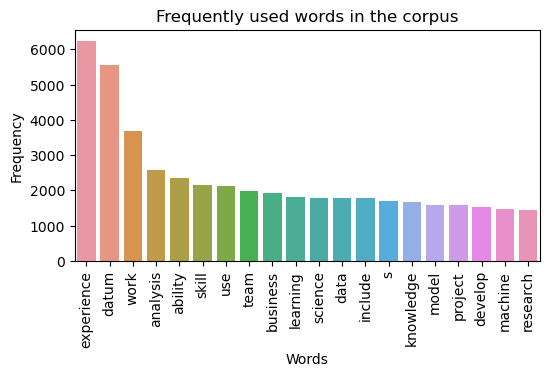

In [92]:
gen_word_freq_plot(preprocessed_words)

### Word Cloud

In [93]:
def gen_word_cloud(words):   
    corpus_text = ' '.join(words)

    # Generate word cloud from the corpus
    wordcloud = WordCloud(width=800, 
                          height=400, 
                          background_color='white', 
                         ).generate(corpus_text)

    # Create the plot
    plt.figure(figsize=(7, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud in the corpus')
    plt.axis('off')
    plt.show()

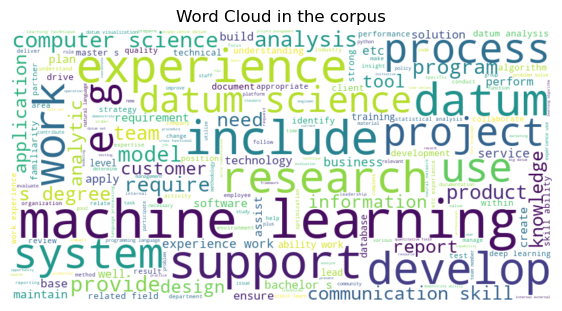

In [94]:
gen_word_cloud(preprocessed_words)

### Analysis of length of the job postings

In [95]:
def gen_len_plot(job_postings_len):

    print(f'Minimum length of the job postings in this corpus: {job_postings_len.min()}')
    print(f'Maximum length of the job postings in this corpus: {job_postings_len.max()}')    
    # Create a figure and axes with desired figsize
    fig, ax = plt.subplots(figsize=(4, 3))

    plt.xlabel('Length')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of length of the job postings in this corpus')

    sns.histplot(job_postings_len, kde=True, ax=ax)    

In [96]:
# Calculate text lengths
job_postings['processed_text_len'] = job_postings['pre_processed_1'].str.len()

Minimum length of the job postings in this corpus: 10
Maximum length of the job postings in this corpus: 17871


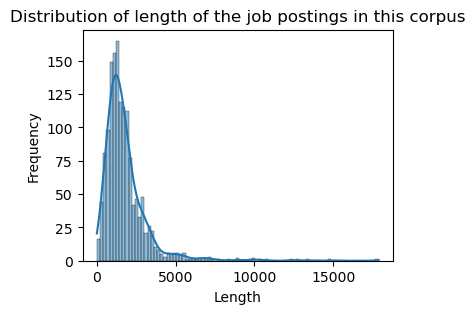

In [97]:
gen_len_plot(job_postings['processed_text_len'])

In [98]:
job_postings[job_postings['processed_text_len'] == 10]

file_name                                          job_title  \
807  85c5b54cf4fedbb6.html  Summer 2020 Data Reporting Internship at The W...   

       skill_set ne_spacy pre_processed pre_processed_1  processed_text_len  
807  LI-JA1-WSJ.       []   LI-JA1-WSJ.      li ja1 wsj                  10

### Unsupervised Learning

In [99]:
X = job_postings['pre_processed_1']

In [100]:
# Create an instance of TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2), 
                             stop_words=list(stop_words))

In [101]:
# Fit and transform the data into TF-IDF features
X_tfidf = vectorizer.fit_transform(X)

In [102]:
X_tfidf.shape

(1458, 146242)

In [103]:
# Get the feature names and their idf scores
feature_names = vectorizer.get_feature_names_out()
idf_scores = vectorizer.idf_

# Combine feature names and their scores into a dictionary
feature_dict = dict(zip(feature_names, idf_scores))

# Sort the dictionary by the scores and get the top 20 features
top_features = sorted(feature_dict.items(), key=lambda x: x[1], )[:100]

# Print the top features and their scores
for feature, score in top_features:
    print(f"Feature: {feature}, Score: {score}")

Feature: experience, Score: 1.1138497257542712
Feature: datum, Score: 1.1683010453584413
Feature: work, Score: 1.2156324200642135
Feature: skill, Score: 1.3697830998914717
Feature: use, Score: 1.4742621699214924
Feature: team, Score: 1.4920404159427763
Feature: analysis, Score: 1.5033144925159942
Feature: ability, Score: 1.5204675717422438
Feature: science, Score: 1.564080847732142
Feature: degree, Score: 1.588472300856301
Feature: include, Score: 1.603397951072977
Feature: knowledge, Score: 1.6096833268879376
Feature: python, Score: 1.6210975281723778
Feature: develop, Score: 1.6223738525319826
Feature: data, Score: 1.6456307146962499
Feature: strong, Score: 1.714623586183201
Feature: computer, Score: 1.7174286371108098
Feature: communication, Score: 1.7188341187195446
Feature: learning, Score: 1.7546289207969004
Feature: development, Score: 1.757548630900235
Feature: business, Score: 1.7722764376104787
Feature: tool, Score: 1.7767374115511039
Feature: machine, Score: 1.78873155833692

In [104]:
X_normalized_tfidf = normalize(X_tfidf)

In [105]:
X_normalized_tfidf.shape

(1458, 146242)

In [106]:
sil = []
for k in range(2, 21, 2):
    kmeans = KMeans(n_clusters = k).fit(X_normalized_tfidf)
    preds = kmeans.labels_
    print(preds)
    sil.append(silhouette_score(X_normalized_tfidf, preds, metric = 'euclidean'))

[1 1 1 ... 0 0 0]
[2 2 2 ... 1 2 1]
[5 5 1 ... 2 1 2]
[2 2 4 ... 2 3 3]
[5 5 6 ... 2 6 1]
[9 9 5 ... 4 7 4]
[12  2  1 ...  3  9  9]
[12 14  1 ...  8  5  3]
[10 13 10 ... 11 10  0]
[ 4  9  5 ... 19  6 11]


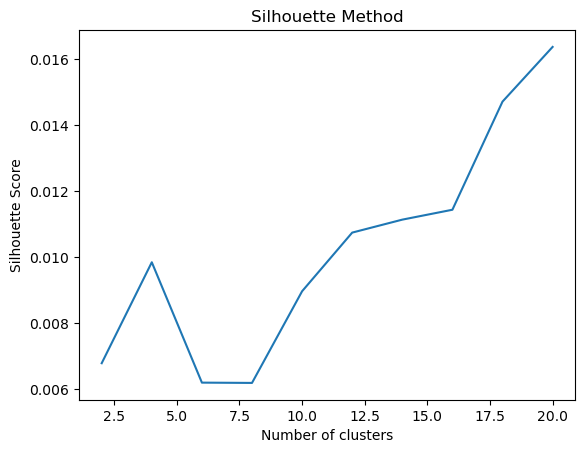

In [107]:
plt.plot(range(2, 21, 2), sil)
plt.title('Silhouette Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

Even after increasing the number of clusters, the silhouette score is very low which indicates that there is no clear separation between the clusters.

In [108]:
cosine_sim_normalized = cosine_similarity(X_normalized_tfidf)
cosine_sim_normalized.shape

(1458, 1458)

In [109]:
cosine_sim_normalized.max().max()

1.0000000000000044

In [110]:
num_documents = cosine_sim_normalized.shape[0]

In [111]:
similar_documents = []

for i in range(num_documents):
    similar_indices = [j for j, similarity_score in enumerate(cosine_sim[i]) if similarity_score > 0.5]
    similar_documents.append(similar_indices)

print(f'Number of similar documents: [{len(similar_documents)}]')

# Print the similar documents
for i, similar_docs in enumerate(similar_documents):
    print(f"Similar documents for Document {i}:")
    for doc_index in similar_docs:
        if doc_index != i:
            print(f" - Document {doc_index}")
    print()


Number of similar documents: [1458]
Similar documents for Document 0:
 - Document 2
 - Document 8
 - Document 27
 - Document 31
 - Document 32
 - Document 33
 - Document 34
 - Document 42
 - Document 49
 - Document 61
 - Document 71
 - Document 77
 - Document 81
 - Document 102
 - Document 106
 - Document 131
 - Document 143
 - Document 177
 - Document 178
 - Document 190
 - Document 191
 - Document 192
 - Document 195
 - Document 208
 - Document 216
 - Document 223
 - Document 233
 - Document 238
 - Document 242
 - Document 245
 - Document 248
 - Document 253
 - Document 265
 - Document 275
 - Document 292
 - Document 293
 - Document 294
 - Document 301
 - Document 312
 - Document 318
 - Document 332
 - Document 337
 - Document 353
 - Document 363
 - Document 373
 - Document 376
 - Document 379
 - Document 408
 - Document 417
 - Document 421
 - Document 426
 - Document 429
 - Document 431
 - Document 439
 - Document 446
 - Document 463
 - Document 500
 - Document 504
 - Document 508
 

 - Document 643
 - Document 664
 - Document 674
 - Document 680
 - Document 687
 - Document 694
 - Document 697
 - Document 700
 - Document 703
 - Document 704
 - Document 707
 - Document 727
 - Document 741
 - Document 745
 - Document 757
 - Document 758
 - Document 771
 - Document 775
 - Document 786
 - Document 793
 - Document 818
 - Document 822
 - Document 824
 - Document 830
 - Document 833
 - Document 836
 - Document 837
 - Document 843
 - Document 852
 - Document 857
 - Document 865
 - Document 871
 - Document 875
 - Document 880
 - Document 885
 - Document 886
 - Document 888
 - Document 899
 - Document 912
 - Document 917
 - Document 930
 - Document 935
 - Document 942
 - Document 943
 - Document 952
 - Document 953
 - Document 958
 - Document 970
 - Document 977
 - Document 986
 - Document 995
 - Document 1002
 - Document 1009
 - Document 1028
 - Document 1031
 - Document 1039
 - Document 1047
 - Document 1049
 - Document 1055
 - Document 1057
 - Document 1064
 - Document 10

 - Document 216
 - Document 221
 - Document 223
 - Document 238
 - Document 245
 - Document 248
 - Document 249
 - Document 252
 - Document 253
 - Document 263
 - Document 265
 - Document 275
 - Document 277
 - Document 279
 - Document 292
 - Document 293
 - Document 294
 - Document 307
 - Document 312
 - Document 317
 - Document 318
 - Document 321
 - Document 324
 - Document 332
 - Document 337
 - Document 346
 - Document 353
 - Document 363
 - Document 376
 - Document 379
 - Document 395
 - Document 417
 - Document 426
 - Document 428
 - Document 429
 - Document 431
 - Document 436
 - Document 443
 - Document 446
 - Document 462
 - Document 472
 - Document 477
 - Document 486
 - Document 495
 - Document 500
 - Document 508
 - Document 516
 - Document 521
 - Document 527
 - Document 529
 - Document 534
 - Document 536
 - Document 545
 - Document 547
 - Document 550
 - Document 564
 - Document 575
 - Document 577
 - Document 579
 - Document 581
 - Document 583
 - Document 585
 - Docum

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [112]:
# Topic Modelling using LDA
num_topics = 10
lda = LatentDirichletAllocation(n_components=num_topics)
lda.fit(X_normalized_tfidf)

LatentDirichletAllocation()

In [113]:
for topic_idx, topic in enumerate(lda.components_):
    print(f'Topic {topic_idx+1}:')
    top_words_indices = topic.argsort()[:-10-1:-1]
    top_words = [feature_names[i] for i in top_words_indices]
    print(", ".join(top_words))

Topic 1:
project course, experience project, thesis, preprint thesis, preprint, thesis draft, course work, player motivate, publication publication, draft optional
Topic 2:
statistical computer, computer language, technique concept, lingual, regression property, sql etc, sap, usage etc, proper usage, test proper
Topic 3:
require incumbent, credentialing, powershell, field minimum, improve wish, meat, practitioner, biomarker, spotify, weblogic
Topic 4:
financial, valuation, datum, large datum, experience, learning deep, business, client, consulting, student
Topic 5:
experience, datum, work, analysis, learning, ability, business, machine, science, skill
Topic 6:
privacy, privacy datum, role model, datum center, demonstrate understanding, meet standard, practice demonstrate, legislative, medication, appropriate action
Topic 7:
qsr, sensor, college university, php, security clearance, presentation data, packaging, circle, base recommendation, hotel
Topic 8:
intelligence, counter, ied, tren

In [189]:
job_postings.head()

file_name                                          job_title  \
0  001b92395ed0fb62.html                   Data Scientist - Beavercreek, OH   
1  00321a48d04fe754.html                 Data Scientist - Seattle, WA 98101   
2  0079c11b2611349f.html                        Data Scientist - Newark, CA   
3  007d9d7b5c09d820.html  Patient Care Assistant / PCA - Med/Surg (Fayet...   
4  00bf37ae19c7dfd7.html               Data Manager / Analyst - Oakland, CA   

                                           skill_set  \
0  Use statistical research methods to analyze da...   
1  Interface with our internal engagement teams a...   
2  Design, develop, document and maintain machine...   
3  Provides all personal care services in accorda...   
4  You possess excellent communication and relati...   

                                            ne_spacy  \
0  [(GIS, ORG), (Python, ORG), (SLQ, ORG), (Table...   
1  [(the Amplero Product Team, ORG), (Python, ORG...   
2  [(Credit, Marketing and/or Operations, ORG), (...   
3   [(PI, ORG), (PI, ORG), (DCH Health System, ORG)]   
4  [(Education, ORG), (Program Evaluation, ORG), ...   

                                       pre_processed  \
0  Use statistical research methods to analyze da...   
1  Interface with our internal engagement teams a...   
2  Design, develop, document and maintain machine...   
3  Provides all personal care services in accorda...   
4  You possess excellent communication and relati...   

                                     pre_processed_1  processed_text_len  
0  use statistical research method analyze datase...                 960  
1  interface internal engagement team client unde...                1323  
2  design develop document maintain machine learn...                1397  
3  provide personal care service accordance plan ...                 972  
4  possess excellent communication relationship b...                1555

### Word2Vec

In [118]:
tokenized_text = X.apply(lambda x: x.split())  # Tokenize the text column

In [182]:
# Train Word2Vec model on the preprocessed data.
model = Word2Vec(tokenized_text, vector_size=2000, window=6, min_count=5, 
                 workers=4, sg=0)

# Extract word vectors from the Word2Vec model
word_vectors = model.wv.vectors

# Normalize the word vectors
normalized_vectors = normalize(word_vectors)


In [183]:
# Apply K-means clustering on the normalized word vectors
sil = []
for k in range(2, 10, 2):
    kmeans = KMeans(n_clusters = k).fit(normalized_vectors)
    preds = kmeans.labels_
    #print(preds)
    sil.append(silhouette_score(normalized_vectors, preds, metric = 'euclidean'))

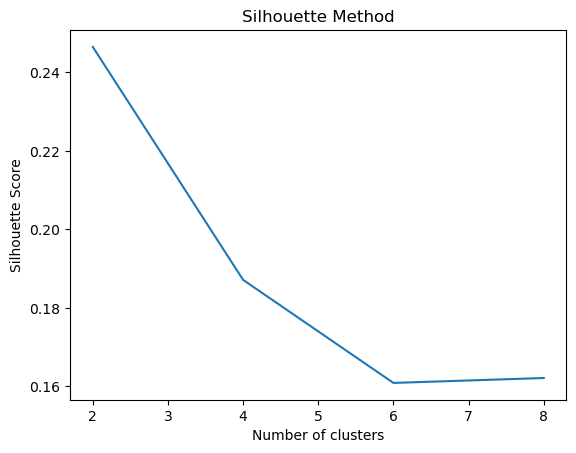

In [184]:
plt.plot(range(2, 10, 2), sil)
plt.title('Silhouette Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

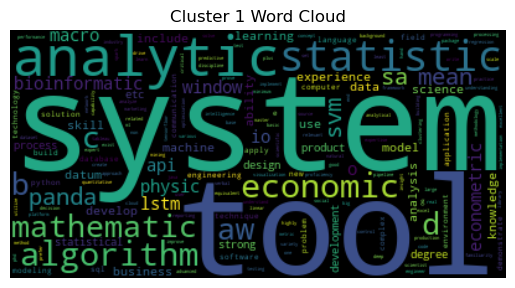

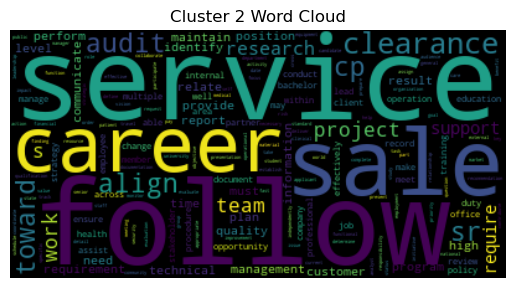

In [188]:
# Apply K-means clustering on the normalized word vectors
num_clusters = 2  
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(normalized_vectors)

# Assign cluster labels to each word in the Word2Vec model
word_clusters = dict(zip(model.wv.index_to_key, kmeans.labels_))

# Visualize word clouds for each cluster
for cluster_index in range(num_clusters):
    # Filter words belonging to the current cluster
    cluster_words = [word for word, cluster_label in word_clusters.items() if cluster_label == cluster_index]

    cluster_text = ' '.join(cluster_words)

    # Generate a word cloud for the cluster
    wordcloud = WordCloud().generate(cluster_text)

    fig, ax = plt.subplots()

    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f'Cluster {cluster_index + 1} Word Cloud')
    ax.axis('off')

    plt.show()


In [ ]:
top2vec